In [1]:
import pandas as pd


Download robo e furto data:

- Can be downloaded [here](http://www.ssp.sp.gov.br/transparenciassp/)
- The downloads are really slow , so I have also stored the raw data [here](https://drive.google.com/drive/folders/1L3rXeIPOtuK1NYG2zsV9eEUeSvX3ojVt)
- No manipulation is done over the raw files, loading them as indicated below

---

## 1. Reading the data

Read robo e furto data

In [2]:
# Initialize the data
all_data = {'roubo': dict(), 'furto': dict()}

# Try to parse each file
for data_type in ['roubo', 'furto']:
    for year in ['2020', '2021']:
        for month in range(1,13):
            
            # Try to load the data
            data = None
            try:
                with open(f"data/roubo_e_furto_raw/{data_type}/DadosBO_{year}_{str(month)}({data_type.upper()} DE VEÍCULOS).xls", 
                          'r', 
                          encoding='utf-16-le' ) as filein:

                    data = pd.read_csv(filein,sep='\t')
            
            except:
                pass
            
            # If some data has been loaded
            if type(data)==pd.core.frame.DataFrame:
                print(f'Usable data for {data_type}, {year}/{str(month)} with {data.shape[0]} records')

                # Append it
                all_data[data_type][year+'_'+str(month)] = data
            
            

Usable data for roubo, 2020/7 with 5838 records
Usable data for roubo, 2020/8 with 5500 records
Usable data for roubo, 2020/9 with 5783 records
Usable data for roubo, 2020/10 with 6716 records
Usable data for roubo, 2020/11 with 6772 records
Usable data for roubo, 2020/12 with 8525 records
Usable data for roubo, 2021/1 with 6770 records
Usable data for roubo, 2021/2 with 6251 records
Usable data for roubo, 2021/3 with 6396 records
Usable data for roubo, 2021/4 with 5703 records
Usable data for roubo, 2021/5 with 5776 records
Usable data for roubo, 2021/6 with 5336 records
Usable data for roubo, 2021/7 with 5363 records
Usable data for roubo, 2021/8 with 5953 records
Usable data for roubo, 2021/9 with 6181 records
Usable data for roubo, 2021/10 with 6713 records
Usable data for furto, 2020/7 with 7557 records
Usable data for furto, 2020/8 with 6755 records
Usable data for furto, 2020/9 with 7109 records
Usable data for furto, 2020/10 with 7788 records
Usable data for furto, 2020/11 with

Check that data formats are consistent across tables

In [3]:
all_formats = []
    
for data_type in ['roubo', 'furto']:
    for date, data in all_data[data_type].items():
        all_formats.append({'data_type': data_type,
                            'date': date,
                            'format': list(data.columns)})

all_formats = pd.DataFrame(all_formats)
display(all_formats.head())

print('Number of unique formats:', all_formats['format'].astype(str).nunique())


,data_type,date,format
0,roubo,2020_7,"[ANO_BO, NUM_BO, NUMERO_BOLETIM, BO_INICIADO, ..."
1,roubo,2020_8,"[ANO_BO, NUM_BO, NUMERO_BOLETIM, BO_INICIADO, ..."
2,roubo,2020_9,"[ANO_BO, NUM_BO, NUMERO_BOLETIM, BO_INICIADO, ..."
3,roubo,2020_10,"[ANO_BO, NUM_BO, NUMERO_BOLETIM, BO_INICIADO, ..."
4,roubo,2020_11,"[ANO_BO, NUM_BO, NUMERO_BOLETIM, BO_INICIADO, ..."


Number of unique formats: 1


One unique format so we can merge all in one table!

In [4]:
# Create empty dataframe
new_cols = ['incident_type', 'file_download_year', 'file_download_month']
final_data = pd.DataFrame(columns=new_cols+list(data.columns))

# Append to this df all the previous data
for data_type in ['roubo', 'furto']:
    for date, data in all_data[data_type].items():
        final_data = pd.concat([final_data,
                                pd.concat([pd.DataFrame([[data_type, int(date.split('_')[0]), int(date.split('_')[1])]]*data.shape[0], columns=new_cols),
                                           data], 
                                          axis=1)],
                               axis=0)
        

Compare number of records with the ones in the load process

In [5]:
final_data[(final_data['incident_type']=='roubo') & 
           (final_data['file_download_year']==2021) & 
           (final_data['file_download_month']==6)].shape[0]

5336

In [6]:
final_data[(final_data['incident_type']=='furto') & 
           (final_data['file_download_year']==2021) & 
           (final_data['file_download_month']==6)].shape[0]

7937

---
## 2. Cleaning the table
Keep a relevant table schema

In [7]:
# Filter and reorder columns
final_data = final_data[['incident_type', 'file_download_year', 'file_download_month', # File info
                         'NUMERO_BOLETIM', 'BO_INICIADO', 'BO_EMITIDO', # Boletin
                         'DATAOCORRENCIA', 'HORAOCORRENCIA', # When it happened
                         'LOGRADOURO', 'NUMERO', 'BAIRRO', 'CIDADE', 'LATITUDE', 'LONGITUDE', 'DESCRICAOLOCAL', # Where it happened
                         'STATUS', 'BO_AUTORIA', # Did it happen? Do we know who did it?
                         'RUBRICA', 'DESDOBRAMENTO', # Some free text info
                         'TIPOPESSOA', 'VITIMAFATAL', 'NATURALIDADE', 'NACIONALIDADE', 'SEXO', 'DATANASCIMENTO', 'IDADE', 'NATUREZAVINCULADA', 'TIPOVINCULO', # WHo did it
                         'PLACA_VEICULO', 'UF_VEICULO', 'CIDADE_VEICULO', 'DESCR_COR_VEICULO', 'DESCR_MARCA_VEICULO', 'ANO_FABRICACAO','ANO_MODELO', 'DESCR_TIPO_VEICULO' # Vehicle info
                        ]].copy()


Check integrity of the latitude longitude data

In [8]:
# Fix coordinates data
final_data['LATITUDE']  = final_data.LATITUDE .astype(str).apply(lambda x: x.replace(',', '.')).astype(float)
final_data['LONGITUDE'] = final_data.LONGITUDE.astype(str).apply(lambda x: x.replace(',', '.')).astype(float)

# Missing values?
display(final_data.LATITUDE.isna().value_counts(normalize=True))
display(final_data.LONGITUDE.isna().value_counts(normalize=True))

# Both informed?
display(final_data.dropna(subset=['LATITUDE']).LONGITUDE.isna().value_counts())
display(final_data.dropna(subset=['LONGITUDE']).LATITUDE.isna().value_counts())

False    0.877352
True     0.122648
Name: LATITUDE, dtype: float64

False    0.877352
True     0.122648
Name: LONGITUDE, dtype: float64

False    198164
Name: LONGITUDE, dtype: int64

False    198164
Name: LATITUDE, dtype: int64

<AxesSubplot:xlabel='LONGITUDE', ylabel='LATITUDE'>

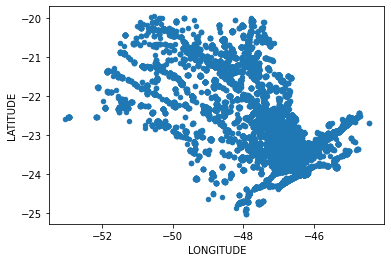

In [9]:
final_data.plot.scatter(x='LONGITUDE', y='LATITUDE')

Define column types

In [10]:
col_types = {
    'file_download_year': float,
    'file_download_month': float,
    'NUMERO': float,
    'LATITUDE': float,
    'LONGITUDE': float,
    'ANO_FABRICACAO': float,
    'ANO_MODELO': float,
    
}

for col in final_data.columns:
    if col in col_types.keys():
        col_type = col_types[col]
    else:
        col_type = str
    print(col)
    final_data[col] = final_data[col].astype(col_type)
    

incident_type
file_download_year
file_download_month
NUMERO_BOLETIM
BO_INICIADO
BO_EMITIDO
DATAOCORRENCIA
HORAOCORRENCIA
LOGRADOURO
NUMERO
BAIRRO
CIDADE
LATITUDE
LONGITUDE
DESCRICAOLOCAL
STATUS
BO_AUTORIA
RUBRICA
DESDOBRAMENTO
TIPOPESSOA
VITIMAFATAL
NATURALIDADE
NACIONALIDADE
SEXO
DATANASCIMENTO
IDADE
NATUREZAVINCULADA
TIPOVINCULO
PLACA_VEICULO
UF_VEICULO
CIDADE_VEICULO
DESCR_COR_VEICULO
DESCR_MARCA_VEICULO
ANO_FABRICACAO
ANO_MODELO
DESCR_TIPO_VEICULO


Convert columns to lower case

In [11]:
final_data = final_data.rename(columns={col:col.lower() for col in final_data.columns}).reset_index().drop(columns='index')
final_data.head()


,incident_type,file_download_year,file_download_month,numero_boletim,bo_iniciado,bo_emitido,dataocorrencia,horaocorrencia,logradouro,numero,...,naturezavinculada,tipovinculo,placa_veiculo,uf_veiculo,cidade_veiculo,descr_cor_veiculo,descr_marca_veiculo,ano_fabricacao,ano_modelo,descr_tipo_veiculo
0,roubo,2020.0,7.0,877931/2020,01/07/2020 00:11:43,01/07/2020 00:11:40,30/06/2020,23:10,RUA JORGE BELLIX,22.0,...,nan,nan,nan,nan,nan,Preta,nan,NaN,NaN,MOTOCICLO
1,roubo,2020.0,7.0,877931/2020,01/07/2020 00:11:43,01/07/2020 00:11:40,30/06/2020,23:10,RUA JORGE BELLIX,22.0,...,nan,nan,EJC8914,SP,PEDREIRA,Cinza,I/HONDA CIVIC LXS,2009.0,NaN,AUTOMOVEL
2,roubo,2020.0,7.0,877966/2020,01/07/2020 00:14:38,01/07/2020 00:14:40,30/06/2020,18:50,RUA MANOEL BANDEIRA,128.0,...,nan,nan,ECH8287,SP,SÃO PAULO,Verde,KAWASAKI/NINJA 650R ABS,2010.0,NaN,MOTOCICLO
3,roubo,2020.0,7.0,877932/2020,01/07/2020 00:20:24,01/07/2020 00:20:16,30/06/2020,22:05,RUA XIRO,43.0,...,nan,nan,nan,nan,nan,Vermelho,nan,NaN,NaN,MOTOCICLO
4,roubo,2020.0,7.0,877932/2020,01/07/2020 00:20:24,01/07/2020 00:20:16,30/06/2020,22:05,RUA XIRO,43.0,...,nan,nan,DOS2121,SP,SÃO PAULO,Preta,I/HONDA CIVIC LXS,2004.0,NaN,AUTOMOVEL


---
## 3. Data to Postgres table

Connect to the db

In [12]:
# Imports
import pandas as pd
import numpy as np
import psycopg2, os
from tqdm import tqdm

#!pip install pyshp
import shapefile

# Establish connection and create its cursor
try: 
    conn = psycopg2.connect(f"host={os.environ['AURORA_POSTGRES_HOST']} dbname={os.environ['AURORA_POSTGRES_DATABASE']} user={os.environ['AURORA_POSTGRES_USERNAME']} password={os.environ['AURORA_POSTGRES_PWD']}")
    cur = conn.cursor()
except psycopg2.Error as e: 
    print("Error: Could not make connection to the Postgres database")
    print(e)
    

### 3.1. Create the table if it doesn't exist

In [13]:
# Redefine columns types
col_types = {
    'file_download_year': 'numeric',
    'file_download_month': 'numeric',
    'numero': 'numeric',
    'latitude': 'numeric',
    'longitude': 'numeric',
    'ano_fabricacao': 'numeric',
    'ano_modelo': 'numeric',
    }

# Create the statement to be executed for table creation
col_types = {k.lower(): v for k,v in col_types.items()}
create_statement = f"CREATE TABLE IF NOT EXISTS staging_tables.stg_roubo_e_furto ({', '.join([k+' '+col_types[k] if k in col_types.keys() else k+' varchar' for k in final_data.columns])})"
cur.execute(create_statement)
conn.commit()



### 3.2. Filter records already contained in table (if existed)

The table may already contain some data previously loaded. Let's make sure we do not copy this records again by filtering them out

In [14]:
cur.execute("""SELECT DISTINCT 
                    incident_type, 
                    file_download_year,
                    file_download_month
                FROM staging_tables.stg_roubo_e_furto""")

current_data_in_table = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
current_data_in_table.sort_values(['incident_type', 'file_download_year', 'file_download_month'])


,incident_type,file_download_year,file_download_month
8,furto,2020.0,8.0
7,furto,2020.0,9.0
14,furto,2020.0,10.0
1,furto,2020.0,12.0
16,furto,2021.0,1.0
3,furto,2021.0,2.0
6,furto,2021.0,3.0
17,furto,2021.0,4.0
9,furto,2021.0,6.0
13,furto,2021.0,10.0


Filter out these data

In [15]:
for i, row in current_data_in_table.iterrows():
    final_data = final_data[~((final_data['incident_type']==row['incident_type']) &
                              (final_data['file_download_year']==row['file_download_year']) &
                              (final_data['file_download_month']==row['file_download_month']))].copy().reset_index().drop(columns='index')

# Display data that remains
final_data.apply(lambda row: row['incident_type']+'-'+str(row['file_download_year'])+'-'+str(row['file_download_month']), axis=1).unique()


array(['roubo-2020.0-7.0', 'roubo-2020.0-8.0', 'roubo-2020.0-9.0',
       'roubo-2020.0-10.0', 'roubo-2020.0-11.0', 'roubo-2021.0-3.0',
       'furto-2020.0-7.0', 'furto-2020.0-11.0', 'furto-2021.0-5.0',
       'furto-2021.0-7.0', 'furto-2021.0-8.0', 'furto-2021.0-9.0'],
      dtype=object)

### 3.2. Populate the table

In [18]:
for i, record in tqdm(final_data.iterrows()):
    insert_statement = f"INSERT INTO staging_tables.stg_roubo_e_furto ({', '.join(record.index)}) VALUES ({', '.join(['%s']*len(record))})"
    cur.execute(insert_statement,
                tuple([v for k,v in record.items()])
               )
    
conn.commit()


85722it [2:42:42,  8.78it/s]


### 3.3 Create a geography columns

In [19]:
# Create the column (ONLY IF NOT WORKING WITH EXISTING TABLE)
#cur.execute("ALTER TABLE staging_tables.stg_roubo_e_furto ADD COLUMN incident_location geometry(Point, 4326);")
#conn.commit()

# Populate the column
cur.execute("UPDATE staging_tables.stg_roubo_e_furto SET incident_location = ST_SetSRID(ST_MakePoint(longitude, latitude), 4326)")
conn.commit()


In [21]:
cur.execute("SELECT incident_type, file_download_year, file_download_month, count(*) FROM staging_tables.stg_roubo_e_furto GROUP BY incident_type, file_download_year, file_download_month")
cur.fetchall()


[('furto', Decimal('2020.0'), Decimal('7.0'), 7557),
 ('furto', Decimal('2020.0'), Decimal('8.0'), 6755),
 ('furto', Decimal('2020.0'), Decimal('9.0'), 7109),
 ('furto', Decimal('2020.0'), Decimal('10.0'), 7788),
 ('furto', Decimal('2020.0'), Decimal('11.0'), 7693),
 ('furto', Decimal('2020.0'), Decimal('12.0'), 7034),
 ('furto', Decimal('2021.0'), Decimal('1.0'), 7516),
 ('furto', Decimal('2021.0'), Decimal('2.0'), 7897),
 ('furto', Decimal('2021.0'), Decimal('3.0'), 8192),
 ('furto', Decimal('2021.0'), Decimal('4.0'), 7665),
 ('furto', Decimal('2021.0'), Decimal('5.0'), 8276),
 ('furto', Decimal('2021.0'), Decimal('6.0'), 7937),
 ('furto', Decimal('2021.0'), Decimal('7.0'), 8188),
 ('furto', Decimal('2021.0'), Decimal('8.0'), 8404),
 ('furto', Decimal('2021.0'), Decimal('9.0'), 8599),
 ('furto', Decimal('2021.0'), Decimal('10.0'), 9680),
 ('roubo', Decimal('2020.0'), Decimal('7.0'), 5838),
 ('roubo', Decimal('2020.0'), Decimal('8.0'), 5500),
 ('roubo', Decimal('2020.0'), Decimal('9.0